In [1]:
import os
import sys
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing.label import LabelEncoder

from torch import Tensor, LongTensor
from torch.utils.data import DataLoader, Sampler
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, LambdaLR

from IPython.display import clear_output
%pylab inline

from slayer import SLayer
from train_functions import *
from src.sharedCode.provider import Provider
from src.sharedCode.experiments import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi

Mon Mar 18 13:03:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:05:00.0 Off |                    0 |
| N/A   29C    P0    32W / 250W |  15639MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   29C    P0    43W / 250W |  16161MiB / 16280MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
cuda_n = 3

In [5]:
class UpperDiagonalThresholdedLogTransform:
    def __init__(self, nu):
        self.b_1 = (torch.Tensor([1, 1]) / np.sqrt(2))
        self.b_2 = (torch.Tensor([-1, 1]) / np.sqrt(2))
        self.nu = nu

    def __call__(self, dgm):
        
#         if dgm.ndimension() == 0:
        if dgm.ndimension() <= 1:
            return dgm

        if dgm.is_cuda:
            self.b_1 = self.b_1.cuda()
            self.b_2 = self.b_2.cuda()

#         start_time = time.time()
        x = torch.mul(dgm, self.b_1.repeat(dgm.size(0), 1))
        x = torch.sum(x, 1)
        y = torch.mul(dgm, self.b_2.repeat(dgm.size(0), 1))
        y = torch.sum(y, 1)
        i = (y <= self.nu)
        y[i] = torch.log(y[i] / self.nu) + self.nu
        ret = torch.stack([x, y], 1)
#         print("upper diag threshold computation - {:.3f}s".format(time.time() - start_time))
        return ret


def pers_dgm_center_init(n_elements):
    centers = []
    while len(centers) < n_elements:
        x = np.random.rand(2)
        if x[1] > x[0]:
            centers.append(x.tolist())

    return torch.Tensor(centers)


def reduce_essential_dgm(dgm):

    if dgm.ndimension() == 0:
        return dgm
    elif dgm.ndimension() == 1:
        return dgm[:].contiguous().view(-1, 1)
    else:
        return dgm[:, 0].contiguous().view(-1, 1)


In [6]:
def _data_setup(params):
    subscripted_views = ['DegreeVertexFiltration_dim_0',
                         'DegreeVertexFiltration_dim_0_essential',
                         'DegreeVertexFiltration_dim_1_essential'
                         ]

    print('Loading provider...')
    dataset = Provider()
    dataset.read_from_h5(params['data_path'])

    assert all(view_name in dataset.view_names for view_name in subscripted_views)

    print('Create data loader...')
    data_train, data_test = train_test_from_dataset(dataset,
                                                    test_size=params['test_ratio'],
                                                    batch_size=params['batch_size'])

    return data_train, data_test, subscripted_views

In [7]:
class MyModel(torch.nn.Module):
    def __init__(self, subscripted_views):
        super(MyModel, self).__init__()
        self.subscripted_views = subscripted_views
        self.transform = UpperDiagonalThresholdedLogTransform(0.1)

        def get_init(n_elements):
            return self.transform(pers_dgm_center_init(n_elements))

        self.dim_0 = SLayer(150, 2, get_init(150), torch.ones(150, 2) * 3)
        self.dim_0_ess = SLayer(50, 1)
        self.dim_1_ess = SLayer(50, 1)
        self.slayers = [self.dim_0,
                        self.dim_0_ess,
                        self.dim_1_ess
                        ]

        self.stage_1 = []
        stage_1_outs = [75, 25, 25]

        for i, (n_in, n_out) in enumerate(zip([150, 50, 50], stage_1_outs)):
            seq = nn.Sequential()
            seq.add_module('linear_1', nn.Linear(n_in, n_out))
            seq.add_module('batch_norm', nn.BatchNorm1d(n_out))
            seq.add_module('drop_out_1', nn.Dropout(0.1))
            seq.add_module('linear_2', nn.Linear(n_out, n_out))
            seq.add_module('relu', nn.ReLU())
            seq.add_module('drop_out_2', nn.Dropout(0.1))

            self.stage_1.append(seq)
            self.add_module('stage_1_{}'.format(i), seq)

        linear_1 = nn.Sequential()
        linear_1.add_module('linear_1', nn.Linear(sum(stage_1_outs), 200))
        linear_1.add_module('batchnorm_1', torch.nn.BatchNorm1d(200))
        linear_1.add_module('relu_1', nn.ReLU())
        linear_1.add_module('linear_2', nn.Linear(200, 100))
        linear_1.add_module('batchnorm_2', torch.nn.BatchNorm1d(100))
        linear_1.add_module('drop_out_2', torch.nn.Dropout(0.1))
        linear_1.add_module('relu_2', nn.ReLU())
        linear_1.add_module('linear_3', nn.Linear(100, 50))
        linear_1.add_module('batchnorm_3', nn.BatchNorm1d(50))
        linear_1.add_module('relu_3', nn.ReLU())
        linear_1.add_module('linear_4', nn.Linear(50, 11))
        linear_1.add_module('batchnorm_4', nn.BatchNorm1d(11))
        self.linear_1 = linear_1

    def forward(self, batch):
        
        x = [batch[n] for n in self.subscripted_views]

        x = [
            [self.transform(dgm) for dgm in x[0]],
            [reduce_essential_dgm(dgm) for dgm in x[1]],
            [reduce_essential_dgm(dgm) for dgm in x[2]]
        ]

        x_sl = [l(xx) for l, xx in zip(self.slayers, x)]

        x = [l(xx) for l, xx in zip(self.stage_1, x_sl)]

        x = torch.cat(x, 1)

        x = self.linear_1(x)

        return x

In [8]:
def train_one_epoch(model, optimizer, train_data, params, criterion, variable_created_by_model):
    
    # training
    train_loss = []
    train_preds = []
    train_targets = []
    model.train(True)
    for i, (batch_input, batch_target) in enumerate(train_data, start=1):
        
        # transform input to tensor
        batch_input, batch_target = data_typing(batch_input, batch_target, params)

        if not variable_created_by_model:
            batch_input = Variable(batch_input)
        batch_target = Variable(batch_target)
        
#         start_time = time.time()
        optimizer.zero_grad()
        batch_output = model(batch_input)
#         print("forward pass - {:3f}s".format(time.time() - start_time))
        loss = criterion(batch_output, batch_target)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        train_preds.extend(list(compute_labels(batch_output)))
        train_targets.extend(list(batch_target.cpu().data.numpy()))
    
    return train_loss, train_preds, train_targets

In [9]:
def train(model, optimizer, train_data, val_data, params, metric=accuracy_score, criterion=nn.CrossEntropyLoss(), variable_created_by_model=True):
    
    mean_train_loss = []
    mean_val_loss = []
    mean_train_metric = []
    mean_val_metric = []

    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.5 ** (epoch // params["lr_ep_step"]))
    
    for epoch in range(params["epochs"]):
        epoch_start_time = time.time()
        
        scheduler.step()
        print("current lr = {}".format(scheduler.get_lr()[0]))
        
        start_time = time.time()
        train_loss, train_preds, train_targets = train_one_epoch(
            model, optimizer, train_data, params, criterion, variable_created_by_model)
        print("train epoch - {:.3f}s".format(time.time() - start_time))
        start_time = time.time()
        val_loss, val_preds, val_targets = validate(
            model, val_data, params, criterion, variable_created_by_model)
        print("validate - {:3f}s".format(time.time() - start_time))

        # print the results for this epoch:
        mean_train_loss.append(np.mean(train_loss))
        mean_val_loss.append(np.mean(val_loss))
        mean_train_metric.append(metric(train_targets, train_preds))
        mean_val_metric.append(metric(val_targets, val_preds))
        
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(mean_train_loss)
        plt.plot(mean_val_loss)
        plt.subplot(122)
        plt.plot(mean_train_metric)
        plt.plot(mean_val_metric)
        plt.gca().set_ylim([0, 1])
        plt.show()
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, params["epochs"], time.time() - epoch_start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(mean_train_loss[-1]))
        print("  validation loss: \t\t\t{:.6f}".format(mean_val_loss[-1]))
        print("  training metric: \t\t\t{:.2f}".format(mean_train_metric[-1]))
        print("  validation metric: \t\t\t{:.2f}".format(mean_val_metric[-1]))
        
#         if mean_train_loss[-1] < epsilon:
#             break

    return mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric

# ? def cross_val_trains

In [10]:
def check_scheduler(optimizer, params):
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.5 ** (epoch // params["lr_ep_step"]))
    for epoch in range(params["epochs"]):
        scheduler.step()
        print(epoch, scheduler.get_lr()[0])

In [13]:
data_path = "data/reddit_12K.h5"

params = {
        'data_path': None,
        'epochs': 200,
        'momentum': 0.5,
        'lr_start': 0.1,
        'lr_ep_step': 20,
        'lr_adaption': 0.5,
        'test_ratio': 0.1,
        'batch_size': 32,
        'cuda': False,
        'cuda_device_id' : cuda_n,
    }

params['data_path'] = data_path

if torch.cuda.is_available():
    params['cuda'] = True
    torch.cuda.set_device(params["cuda_device_id"])

subscripted_views = [
    'DegreeVertexFiltration_dim_0',
    'DegreeVertexFiltration_dim_0_essential',
    'DegreeVertexFiltration_dim_1_essential'
]

print('Create model...')
model = MyModel(subscripted_views)
if params["cuda"]:
    model.cuda(params["cuda_device_id"])

print("Create optimizer...")
optimizer = optim.SGD(model.parameters(),
                      lr=params['lr_start'],
                      momentum=params['momentum'])

check_scheduler(optimizer, params)
# mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric = train(model, optimizer, data_train, data_test, params)

Create model...
Create optimizer...
0 0.1
1 0.1
2 0.1
3 0.1
4 0.1
5 0.1
6 0.1
7 0.1
8 0.1
9 0.1
10 0.1
11 0.1
12 0.1
13 0.1
14 0.1
15 0.1
16 0.1
17 0.1
18 0.1
19 0.1
20 0.05
21 0.05
22 0.05
23 0.05
24 0.05
25 0.05
26 0.05
27 0.05
28 0.05
29 0.05
30 0.05
31 0.05
32 0.05
33 0.05
34 0.05
35 0.05
36 0.05
37 0.05
38 0.05
39 0.05
40 0.025
41 0.025
42 0.025
43 0.025
44 0.025
45 0.025
46 0.025
47 0.025
48 0.025
49 0.025
50 0.025
51 0.025
52 0.025
53 0.025
54 0.025
55 0.025
56 0.025
57 0.025
58 0.025
59 0.025
60 0.0125
61 0.0125
62 0.0125
63 0.0125
64 0.0125
65 0.0125
66 0.0125
67 0.0125
68 0.0125
69 0.0125
70 0.0125
71 0.0125
72 0.0125
73 0.0125
74 0.0125
75 0.0125
76 0.0125
77 0.0125
78 0.0125
79 0.0125
80 0.00625
81 0.00625
82 0.00625
83 0.00625
84 0.00625
85 0.00625
86 0.00625
87 0.00625
88 0.00625
89 0.00625
90 0.00625
91 0.00625
92 0.00625
93 0.00625
94 0.00625
95 0.00625
96 0.00625
97 0.00625
98 0.00625
99 0.00625
100 0.003125
101 0.003125
102 0.003125
103 0.003125
104 0.003125
105 0.003

In [14]:
import os

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if directory != "" and not os.path.exists(directory):
        os.makedirs(directory)
        
def save_res(res, path):
    ensure_dir(path)
    with open(path, "w") as f:
        f.write(str(res))
        
def load_res(path):
    with open(path) as f:
        res = f.read()
    return eval(res)

def load_results(problem):
    train_loss_l = load_res("results/" + problem + "/train_loss")
    val_loss_l = load_res("results/" + problem + "/val_loss")
    train_metric_l = load_res("results/" + problem + "/train_auc")
    val_metric_l = load_res("results/" + problem + "/val_auc")
    return train_loss_l, val_loss_l, train_metric_l, val_metric_l
    
def save_results(problem, train_loss_l, val_loss_l, train_metric_l, val_metric_l):
    save_res(train_loss_l, "results/" + problem + "/" + "train_loss")
    save_res(val_loss_l, "results/" + problem + "/" + "val_loss")
    save_res(train_metric_l, "results/" + problem + "/" + "train_auc")
    save_res(val_metric_l, "results/" + problem + "/" + "val_auc")
    print("saved.")

In [15]:
def create_model(subscripted_views, params):
    print('Create model...')
    model = MyModel(subscripted_views)
    if params["cuda"]:
        model.cuda(params["cuda_device_id"])

    print("Create optimizer...")
    optimizer = optim.SGD(model.parameters(),
                          lr=params['lr_start'],
                          momentum=params['momentum'])
    
    return model, optimizer

In [16]:
def cross_val_train(problem, dataset, subscripted_views, cv, params, load=True, wanted_views=None):
    """
    Perform training and validation on each fold and save the result. 
    """

    sample_labels = list(dataset.sample_labels)
    label_encoder = LabelEncoder().fit(sample_labels)
    sample_labels = label_encoder.transform(sample_labels)

    label_map = lambda l: int(label_encoder.transform([l])[0])
    collate_fn = PersistenceDiagramProviderCollate(dataset, label_map=label_map, wanted_views=wanted_views)
    
    cv_splits = list(cv.split([0] * len(sample_labels), sample_labels))
    
    if load:
        train_loss_l, val_loss_l, train_metric_l, val_metric_l = load_results(problem)
        test_metric = list(map(lambda x: x[-1], val_metric_l))
        print("test metric mean:", np.mean(test_metric))
        print("test metric std:", np.std(test_metric))
        print(list(map(lambda x: np.round(x, 2), test_metric)))
    else:
        train_loss_l, val_loss_l, train_metric_l, val_metric_l, test_metric = [], [], [], [], []

    for i in range(len(test_metric), len(cv_splits)):
        
        train_i, test_i = cv_splits[i]
        
        train_data = DataLoader(dataset,
                                batch_size=params["batch_size"],
                                collate_fn=collate_fn,
                                shuffle=False,
                                sampler=SubsetRandomSampler(train_i.tolist()))

        val_data = DataLoader(dataset,
                               batch_size=params["batch_size"],
                               collate_fn=collate_fn,
                               shuffle=False,
                               sampler=SubsetRandomSampler(test_i.tolist()))

        model, optimizer = create_model(subscripted_views, params)
        mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric = train(
            model, optimizer, train_data, val_data, params, metric=accuracy_score, 
            criterion=nn.CrossEntropyLoss(), variable_created_by_model=True)

        train_loss_l.append(mean_train_loss)
        val_loss_l.append(mean_val_loss)
        train_metric_l.append(mean_train_metric)
        val_metric_l.append(mean_val_metric)
        test_metric.append(mean_val_metric[-1])

        save_results(problem, train_loss_l, val_loss_l, train_metric_l, val_metric_l)

    print("test metric mean:", np.mean(test_metric))
    print("test metric std:", np.std(test_metric)) 
    
    return test_metric

## Reddit12K classification results

In [17]:
data_path = "data/reddit_12K.h5"

params = {
        'data_path': None,
        'epochs': 200,
        'momentum': 0.5,
        'lr_start': 0.1,
        'lr_ep_step': 20,
        'lr_adaption': 0.5,
        'n_splits' : 5,
#         'test_ratio': 0.1,
        'batch_size': 32,
        'cuda': False,
        'cuda_device_id' : cuda_n,
    }

params['data_path'] = data_path

if torch.cuda.is_available():
    params['cuda'] = True
    torch.cuda.set_device(params["cuda_device_id"])

subscripted_views = [
    'DegreeVertexFiltration_dim_0',
    'DegreeVertexFiltration_dim_0_essential',
    'DegreeVertexFiltration_dim_1_essential'
]

print('Loading provider...')
dataset = Provider()
dataset.read_from_h5(params['data_path'])

assert all(view_name in dataset.view_names for view_name in subscripted_views)

cv = StratifiedKFold(n_splits=params["n_splits"])
problem = "reddit_12K"

Loading provider...


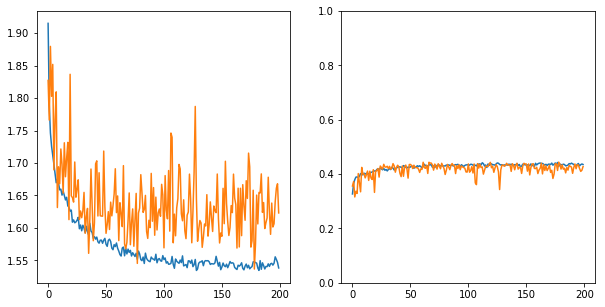

Epoch 200 of 200 took 38.509s
  training loss (in-iteration): 	1.538257
  validation loss: 			1.623025
  training metric: 			0.44
  validation metric: 			0.43
saved.
test metric mean: 0.41588163269556533
test metric std: 0.017812274183686288


[0.42343096234309624,
 0.41380753138075316,
 0.38238993710691827,
 0.4322282836760386,
 0.4275514489710206]

In [19]:
cross_val_train(problem, dataset, subscripted_views, cv, params, load=True)

In [ ]:
# reddit 5k - 5 classes, 5k graphs
# reddit 12k - 11 classes, 12 graphs